<h1>Submitted by : Ishan Ojha , CS-21, ASSIGNMENT NO : 7
 </h1>

<h3><b>Building the word2vec model using
gensim</b></h3>

In [1]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install gensim


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings(action='ignore')
#data processing
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
#modelling
from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nitro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# reading the data from the text.csv fileee
data = pd.read_csv('data/text.csv',header=None)
data.head()

,0
0,room kind clean strong smell dogs. generally a...
1,stayed crown plaza april april . staff friendl...
2,booked hotel hotwire lowest price could find. ...
3,stayed husband sons way alaska cruise. loved h...
4,girlfriends stayed celebrate th birthdays. pla...


In [5]:
def pre_process(text):
    # convert to lowercase
    text = str(text).lower()
    # remove all special characters and keep only alpha numeric characters andspaces
    text = re.sub(r'[^A-Za-z0-9\s.]',r'',text)
    #remove new lines
    text = re.sub(r'\n',r' ',text)
    # remove stop words
    text = " ".join([word for word in text.split() if word not in stopWords])
    return text

In [6]:
pre_process(data[0][50])

'agree fancy. everything needed. breakfast pool hot tub nice shuttle airport later checkout time. noise issue tough sleep through. awhile forget noisy door nearby noisy guests. complained management later email credit compd us amount requested would return.'

In [7]:
data[0] = data[0].map(lambda x: pre_process(x))
data[0][1].split('.')[:5]

['stayed crown plaza april april ',
 ' staff friendly attentive',
 ' elevators tiny ',
 ' food restaurant delicious priced little high side',
 ' course washington dc']

In [8]:
# converting each sentence to to a list of lists
corpus = []
for line in data.iloc[:, 0]:
    for sentence in line.split('.'):
        words = [x for x in sentence.split()]
        corpus.append(words)

# view results
corpus[:2]

[['room', 'kind', 'clean', 'strong', 'smell', 'dogs'],
 ['generally', 'average', 'ok', 'overnight', 'stay', 'youre', 'fussy']]

In [9]:
data = data[0].map(lambda x: x.split('.'))
corpus = []
for i in (range(len(data))):
    for line in data[i]:
        words = [x for x in line.split()]
        corpus.append(words)
print(corpus[:2])

[['room', 'kind', 'clean', 'strong', 'smell', 'dogs'], ['generally', 'average', 'ok', 'overnight', 'stay', 'youre', 'fussy']]


In [10]:
# use gensim models
phrases = Phrases(sentences=corpus,min_count=25,threshold=50)
bigram = Phraser(phrases)
for index,sentence in enumerate(corpus):
    corpus[index] = bigram[sentence]
corpus[111]

['connected', 'rivercenter', 'mall', 'downtown', 'san_antonio']

In [11]:
corpus[111]

['connected', 'rivercenter', 'mall', 'downtown', 'san_antonio']

In [12]:
corpus[9]

['course', 'washington_dc']

BUILDING THE MODEL

In [13]:
size = 100
window_size = 2
epochs = 100
min_count = 2
workers = 4
sg = 1


In [14]:
# train
model = Word2Vec(corpus,sg=1,window=window_size,vector_size=size, 
                 min_count=min_count,workers=workers,epochs=epochs)

In [15]:
# save the model
model.save('word2vec.model')

In [16]:
# load the model for evaluation
model = Word2Vec.load('word2vec.model')

In [17]:
# evaluate embeddings
model.wv.most_similar('san_diego')

[('san_antonio', 0.7907506227493286),
 ('memphis', 0.7834407687187195),
 ('san_francisco', 0.7792276740074158),
 ('austin', 0.7452000379562378),
 ('la', 0.7377185821533203),
 ('phoenix', 0.7356073260307312),
 ('dallas', 0.7336931824684143),
 ('boston', 0.733062207698822),
 ('sf', 0.7262304425239563),
 ('sd', 0.7186099886894226)]

In [18]:
model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[('queen', 0.7158124446868896)]

In [19]:
text = ['los_angeles','indianapolis', 'holiday', 'san_antonio','new_york']

model.wv.doesnt_match(text)

'holiday'

In [20]:
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import logging
import os
import gensim

logging.getLogger('tensorflow').setLevel(logging.ERROR)


In [21]:
file_name = "word2vec.model"
model = gensim.models.keyedvectors.KeyedVectors.load(file_name)

In [22]:
max_size = len(model.wv.index_to_key) - 1

In [23]:
w2v = np.zeros((max_size,model.layer1_size))

In [24]:
if not os.path.exists('projections'):
    os.makedirs('projections')

In [25]:
with open("projections/metadata.tsv", 'w+') as file_metadata:
    for i, word in enumerate(model.wv.index_to_key[:max_size]):
        #store the embeddings of the word
        w2v[i] = model.wv[word]
        #write the word to a file
        file_metadata.write(word + '\n')

In [26]:
import os
import numpy as np
import tensorflow.compat.v1 as tf
from tensorboard.plugins import projector

tf.disable_v2_behavior()

# Create the projection directory if it doesn't exist
LOG_DIR = 'projections'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

# Start a TensorFlow session
sess = tf.InteractiveSession()

# Create a non-trainable embedding variable on CPU
with tf.device("/cpu:0"):
    embedding = tf.Variable(w2v, trainable=False, name='embedding')

# Initialize variables
sess.run(tf.global_variables_initializer())

# Create a saver and summary writer
saver = tf.train.Saver()
writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

# Create a ProjectorConfig and add metadata
config = projector.ProjectorConfig()
embed = config.embeddings.add()
embed.tensor_name = embedding.name
embed.metadata_path = 'metadata.tsv'  # must be inside the LOG_DIR

# Write projector config
projector.visualize_embeddings(writer, config)

# Save the model checkpoint
saver.save(sess, os.path.join(LOG_DIR, 'model.ckpt'), global_step=max_size)


'projections\\model.ckpt-28070'

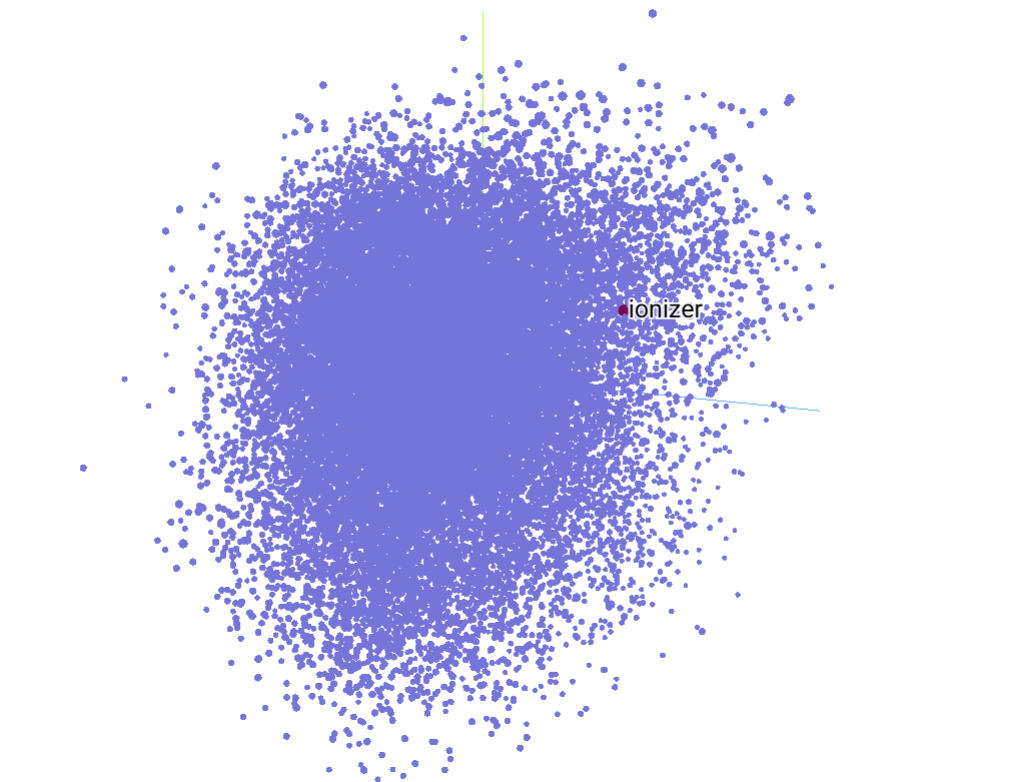

In [30]:
import os
import signal
import socket
import psutil

def free_port(port):
    for conn in psutil.net_connections():
        if conn.laddr.port == port:
            pid = conn.pid
            if pid:
                os.kill(pid, signal.SIGTERM)
                print(f"Process on port {port} (PID {pid}) terminated.")
                return
    print(f"No process found on port {port}.")

free_port(8000)


No process found on port 8000.
